# 20 vs 20 signal processing

### There is 2 ways to process signal
* Based on exact tags count using fragment size
    UNIQUE_BAM -> PILEUP_BED -> TAGS -> intersect with given regions bed and compute intersection
* Based on bigwigs
    UNIQUE_BAM -> BIGWIG -> bigWigAverageOverBed

### Interesting LOCI
/mnt/stripe/bio/raw-data/aging/loci_of_interest/

### Code
```
mkdir /mnt/stripe/bio/experiments/signal
cd /mnt/stripe/bio/experiments/signal
mkdir H3K27ac
cp /mnt/stripe/bio/experiments/configs/Y20O20/browsers/browser_tracks/*k27ac*_unique.bw H3K27ac
mkdir H3K27me3
cp /mnt/stripe/bio/experiments/configs/Y20O20/browsers/browser_tracks/*k27me3*_unique.bw H3K27me3
mkdir H3K36me3
cp /mnt/stripe/bio/experiments/configs/Y20O20/browsers/browser_tracks/*k36me3*_unique.bw H3K36me3
mkdir H3K4me1
cp /mnt/stripe/bio/experiments/configs/Y20O20/browsers/browser_tracks/*k4me1*_unique.bw H3K4me1/
mkdir H3K4me3
cp /mnt/stripe/bio/experiments/configs/Y20O20/browsers/browser_tracks/*k4me3*_unique.bw H3K4me3/
mkdir meth
cp /mnt/stripe/bio/experiments/configs/Y20O20/browsers/browser_tracks/*mlevel*.bw meth/

DIR=/mnt/stripe/bio/experiments/signal
for M in $(ls $DIR); do 
    echo Processing $M; 
    for F in $(find /mnt/stripe/bio/raw-data/aging/loci_of_interest/ -name "*.bed"); do  
        echo $F; N=${F%%.bed}; N=${N##*/}; echo $N; 
        bash /mnt/stripe/washu/parallel/bw_signals.sh $DIR/$M $F $N /mnt/stripe/bio/genomes/hg19/hg19.chrom.sizes;         done; 
done | tee log.txt
```

# Signal in peaks distribution

In [1]:
# Configure
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display
# Actually we don't use, just for fancy styling
import seaborn as sns

from enum import Enum
from collections import namedtuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing

import re


class Normalization(Enum):
    NONE = 1
    SCALED = 2

Group = namedtuple('Group', 'name color prefix')
OD_GROUP = Group('OD', 'blue', '')
YD_GROUP = Group('YD', 'red', '')
def od_yd_groupf(c):
    if re.match('.*od\\d+.*', c, flags=re.IGNORECASE):
        return OD_GROUP
    return YD_GROUP


def signal_pca(x0, 
               title, 
               groups=None,
               scale=Normalization.NONE):
    if groups is None:
        groups = [od_yd_groupf(n) for n in x0.index]
    x = x0
    if scale == Normalization.SCALED:
        x = preprocessing.scale(x0)

    pca = PCA(n_components=2)
    x_r = pca.fit_transform(x)
    for g in set(groups):
        gfilter = np.asarray([g == n for n in groups])
        plt.scatter(x_r[gfilter, 0], x_r[gfilter, 1] , color=g.color, alpha=.8, label=g.name)

    for g, label, x, y in zip(groups, 
                              [re.search('[yo]d\\d+', n, flags=re.IGNORECASE).group(0) for n in x0.index], 
                              x_r[:, 0], x_r[:, 1]):
        plt.annotate(g.prefix + label, 
                     xy=(x, y), 
                     xytext=(5, 0), 
                     color=g.color,
                     textcoords='offset points', 
                     ha='right', va='bottom')
    plt.title(title)
    plt.xlabel('PC1 {}%'.format(int(pca.explained_variance_ratio_[0] * 100)))
    plt.ylabel('PC2 {}%'.format(int(pca.explained_variance_ratio_[1] * 100)))    

def signal_pca_all(x, title, groups=None):
    '''Plot all the scaled variants of PCA'''
    plt.figure(figsize=(20, 5))
    plt.subplot(1,4,1)
    signal_pca(x, title, groups=groups)
    plt.subplot(1,4,2)
    signal_pca(x, 'SCALED {}'.format(title), scale=Normalization.SCALED, groups=groups)
    plt.subplot(1,4,3)
    signal_pca(np.log1p(x), 'LOG {}'.format(title), groups=groups)
    plt.subplot(1,4,4)
    signal_pca(np.log1p(x), 'SCALED LOG {}'.format(title), scale=Normalization.SCALED, groups=groups)
    plt.show()

/Users/oleg/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Mean values SCATTER / HISTOGRAM / MA

In [14]:
class Plot(Enum):
    SCATTER = 1
    HISTOGRAM = 2
    MA = 3

def mean_regions(df, title, ax=None, type = Plot.SCATTER):    
    ods=[c for c in df.columns if 
         re.match('.*od\\d+.*', c, flags=re.IGNORECASE) and not re.match('.*input.*', c, flags=re.IGNORECASE)]
    yds=[c for c in df.columns if 
         re.match('.*yd\\d+.*', c, flags=re.IGNORECASE) and not re.match('.*input.*', c, flags=re.IGNORECASE)]
    
    signal = pd.DataFrame()
    signal["ODS"] = df[ods].mean(axis=1)
    signal["YDS"] = df[yds].mean(axis=1)

    is_separate_plot = ax is None
    if is_separate_plot:
        plt.figure(figsize=(7,7))
        ax=plt.subplot()
    
    if type == Plot.MA:
        signal["M"] = np.log1p(signal["ODS"]) - np.log1p(signal["YDS"])
        signal["A"] = 0.5 * (np.log1p(signal["ODS"]) + np.log1p(signal["YDS"]))
        ax.scatter(signal["A"], signal["M"], alpha=.3, s=1)
        ax.set_xlabel("A")
        ax.set_ylabel("M")
        
        xmin = np.min(ax.get_xlim())
        xmax = np.max(ax.get_xlim())
        ax.plot([xmin, xmax], [0,0], c="red", alpha=0.75, lw=1, ls='dotted')
        ax.set_xlim([xmin, xmax])
        
    elif type == Plot.HISTOGRAM:
        signal["ODS"] = np.log1p(signal["ODS"]) / np.log(10)
        signal["YDS"] = np.log1p(signal["YDS"]) / np.log(10)

        ax.hist(signal["ODS"], color=OD_GROUP.color, bins=100, alpha=0.3, label="ODS")
        ax.hist(signal["YDS"], color=YD_GROUP.color, bins=100, alpha=0.3, label="YDS")
        ax.legend()
    else:
        ax.scatter(signal["ODS"], signal["YDS"], alpha=.3, s=1)
        ax.set_xlabel("mean ODS")
        ax.set_ylabel("mean YDS")
        # x = y
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        # now plot both limits against eachother
        ax.plot(lims, lims, 'r-', alpha=0.75, lw=1, ls='dotted')
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
    ax.set_title(title)
    
    if is_separate_plot:
        plt.show()

def mean_boxplots(df, title, ax=None):
    signal = df.mean(axis=1).to_frame("value")
    signal.index = [re.search('[yo]d\\d+', n, flags=re.IGNORECASE).group(0) for n in signal.index]
    signal["age"] = "ODS"
    signal.loc[signal.index.str.startswith("y"), "age"] = "YDS"
    
    is_separate_plot = ax is None
    if is_separate_plot:
        plt.figure(figsize=(7,7))
        ax=plt.subplot()
    
    age_labels = list(reversed(sorted(list(set(signal['age'])))))
    sns.boxplot(x="age", y="value", data=signal, palette="Set3", linewidth=1.0, order=age_labels, ax=ax)
    sns.swarmplot(x="age", y="value", data=signal, color=".25", order=age_labels, ax=ax)

    for i, age_label in enumerate(age_labels):
        age_data = signal[signal['age'] == age_label]
        for j, label in enumerate(age_data.index):
            ax.annotate(label, xy=(i, age_data.iloc[j,:]['value']), 
                        xytext=(5, 0),
                        color= OD_GROUP.color if age_label == "YDS" else YD_GROUP.color,
                        textcoords='offset points')

    ax.set_title(title)
    
    if is_separate_plot:
        plt.show()     

## DiffBind score processing

In [15]:
import subprocess
import math
import tempfile

# See documents on how to compute scores
# https://docs.google.com/document/d/1zH5cw5Zal546xkoFFCVqhhYmf3742efhddz5cqpD9PQ/edit?usp=sharing
def score(cond, cont, scale):
    if scale > 1:
        scale = 1
    if scale != 0:
        cont = math.ceil(cont * scale)
    # According to pv.get_reads() function, if reads number is < 1 than it should be 1
    return max(1, cond - cont)

def process_scores(df, sizes, records):
    scores_processed = pd.DataFrame()
    sizes_processed = pd.DataFrame(columns=['name', 'size'])
    for cond, cont, g in records:
        scale = sizes.loc[cond]['size'] / sizes.loc[cont]['size']
        if g is None:
            prefix = ''
        else:
            prefix= g.prefix
        scores_processed[prefix + cond] = [score(z[0], z[1], scale) for z in zip(df[cond], df[cont])]
        sizes_processed.loc[len(sizes_processed)] = (prefix + cond, sizes.loc[cond]['size'])
#         print(prefix + cond, 'size', sizes.loc[cond]['size'], cont, 'size', sizes.loc[cont]['size'], 'scale', scale)
    return scores_processed, sizes_processed


def process_diffbind(records, df, sizes, ods, yds):
    if records[0][2] is not None:
        groups = [p[2] for p in records]
    else:
        groups = None
    scores, libsizes = process_scores(df, sizes, records)
    
    plt.figure(figsize=(20, 5))
    mean_regions(scores, title='diffbind score', ax=plt.subplot(1,4,1), type = Plot.SCATTER)
    mean_regions(scores, title='MA diffbind score', ax=plt.subplot(1,4,2), type = Plot.MA)
    mean_regions(scores, title='LOG diffbind score', ax=plt.subplot(1,4,3), type = Plot.HISTOGRAM)
    mean_boxplots(scores.T, title='diffbind', ax=plt.subplot(1,4,4))
    plt.show()
        
    signal_pca_all(scores.T, 'Scores', groups=groups)

    print('TMM normalization')
    scores_tmpfile = tempfile.NamedTemporaryFile(prefix='scores', suffix='.tsv').name
    scores.to_csv(scores_tmpfile, index=False, sep='\t')
    print('Saved scores to', scores_tmpfile)
    resultfile=scores_tmpfile.replace('.tsv', '_tmm.tsv')
    
    sizes_tmpfile = tempfile.NamedTemporaryFile(prefix='sizes', suffix='.tsv').name
    libsizes.to_csv(sizes_tmpfile, index=False, sep='\t', header=None)
    print('Saved sizes to', sizes_tmpfile)
    
    print('TMM normalization using R')
    cmd="Rscript /home/oleg/work/washu/R/tmm.R " + scores_tmpfile + " " + sizes_tmpfile + " " + resultfile
    subprocess.run(cmd,  shell=True)

    # Difference between DBA_SCORE_TMM_MINUS_FULL and DBA_SCORE_TMM_MINUS_FULL_CPM is in bCMP
    print('TMM Scores DBA_SCORE_TMM_MINUS_FULL_CPM')
    scores_tmm = pd.read_csv(resultfile, sep='\t') * 10000000
    # counts <- counts * mean(res$samples$lib.size)
    scores_tmm_full = scores_tmm.T * sizes.loc[ods+yds]['size'].mean()
    plt.figure(figsize=(20, 5))
    plt.subplot(1,4,1)
    signal_pca(scores_tmm.T, 'TMM DBA_SCORE_TMM_MINUS_FULL_CPM', groups=groups)
    plt.subplot(1,4,2)
    signal_pca(np.log1p(scores_tmm.T), 'LOG TMM DBA_SCORE_TMM_MINUS_FULL_CPM', groups=groups)
    plt.subplot(1,4,3)
    signal_pca(scores_tmm_full, 'TMM DBA_SCORE_TMM_MINUS_FULL', groups=groups)
    plt.subplot(1,4,4)
    signal_pca(np.log1p(scores_tmm_full), 'LOG TMM DBA_SCORE_TMM_MINUS_FULL', groups=groups)
    plt.show()

    return(scores_tmm)

# Process all the analysis

In [21]:
def process(folder, name):
    print('Processing signal data')
    file=folder + '/{0}/{0}_{1}.tsv'
    for type in ['raw', 'rpm', 'rpkm']:
        f = file.format(name, type)
        try:
            print(f)
            df = pd.read_csv(f, sep='\t')
            od_input = [c for c in df.columns.values if re.match('.*od.*input.*', c, flags=re.IGNORECASE)][0]
            yd_input = [c for c in df.columns.values if re.match('.*yd.*input.*', c, flags=re.IGNORECASE)][0]
            signal = df.drop(['chr', 'start', 'end', od_input, yd_input], axis=1)
            plt.figure(figsize=(20, 5))
            mean_regions(df, title=type, ax=plt.subplot(1,4,1), type = Plot.SCATTER)
            mean_regions(df, title='MA {}'.format(type), ax=plt.subplot(1,4,2), type = Plot.MA)
            mean_regions(df, title='LOG {}'.format(type), ax=plt.subplot(1,4,3), type = Plot.HISTOGRAM)
            mean_boxplots(signal.T, title=type, ax=plt.subplot(1,4,4))
            plt.show()

            signal_pca_all(signal.T, type)
        except FileNotFoundError:
            print('File not found: {}'.format(f))
            
    print('Processing diffbind normalization')
    f=folder + '/{0}/{0}_raw.tsv'.format(name)
    try:
        df = pd.read_csv(f, sep='\t')
        od_input = [c for c in df.columns.values if re.match('.*od.*input.*', c, flags=re.IGNORECASE)][0]
        yd_input = [c for c in df.columns.values if re.match('.*yd.*input.*', c, flags=re.IGNORECASE)][0]    
        ods=[c for c in df.columns if 
             re.match('.*od\\d+.*', c, flags=re.IGNORECASE) and not re.match('.*input.*', c, flags=re.IGNORECASE)]
        yds=[c for c in df.columns if 
             re.match('.*yd\\d+.*', c, flags=re.IGNORECASE) and not re.match('.*input.*', c, flags=re.IGNORECASE)]

        sizes = folder + '/{0}/sizes.tsv'.format(name)
        sizesdf = pd.read_csv(sizes, sep='\t', names=('name', 'size'))
        sizesdf.index = sizesdf['name']
        sizesdf = sizesdf.drop('name', axis=1)
        sizesdf['size'] = sizesdf['size'] / 1000000

        records = [(d, od_input, OD_GROUP) for d in ods] + [(d, yd_input, YD_GROUP) for d in yds]
        process_diffbind(records, df, sizesdf, ods, yds)
    except FileNotFoundError:
        print('File not found: {}'.format(f))


# K27ac results

Processing signal data
/mnt/stripe/bio/experiments/signal/H3K27ac/ucsc_cpgIslandExt.hg19/ucsc_cpgIslandExt.hg19_raw.tsv


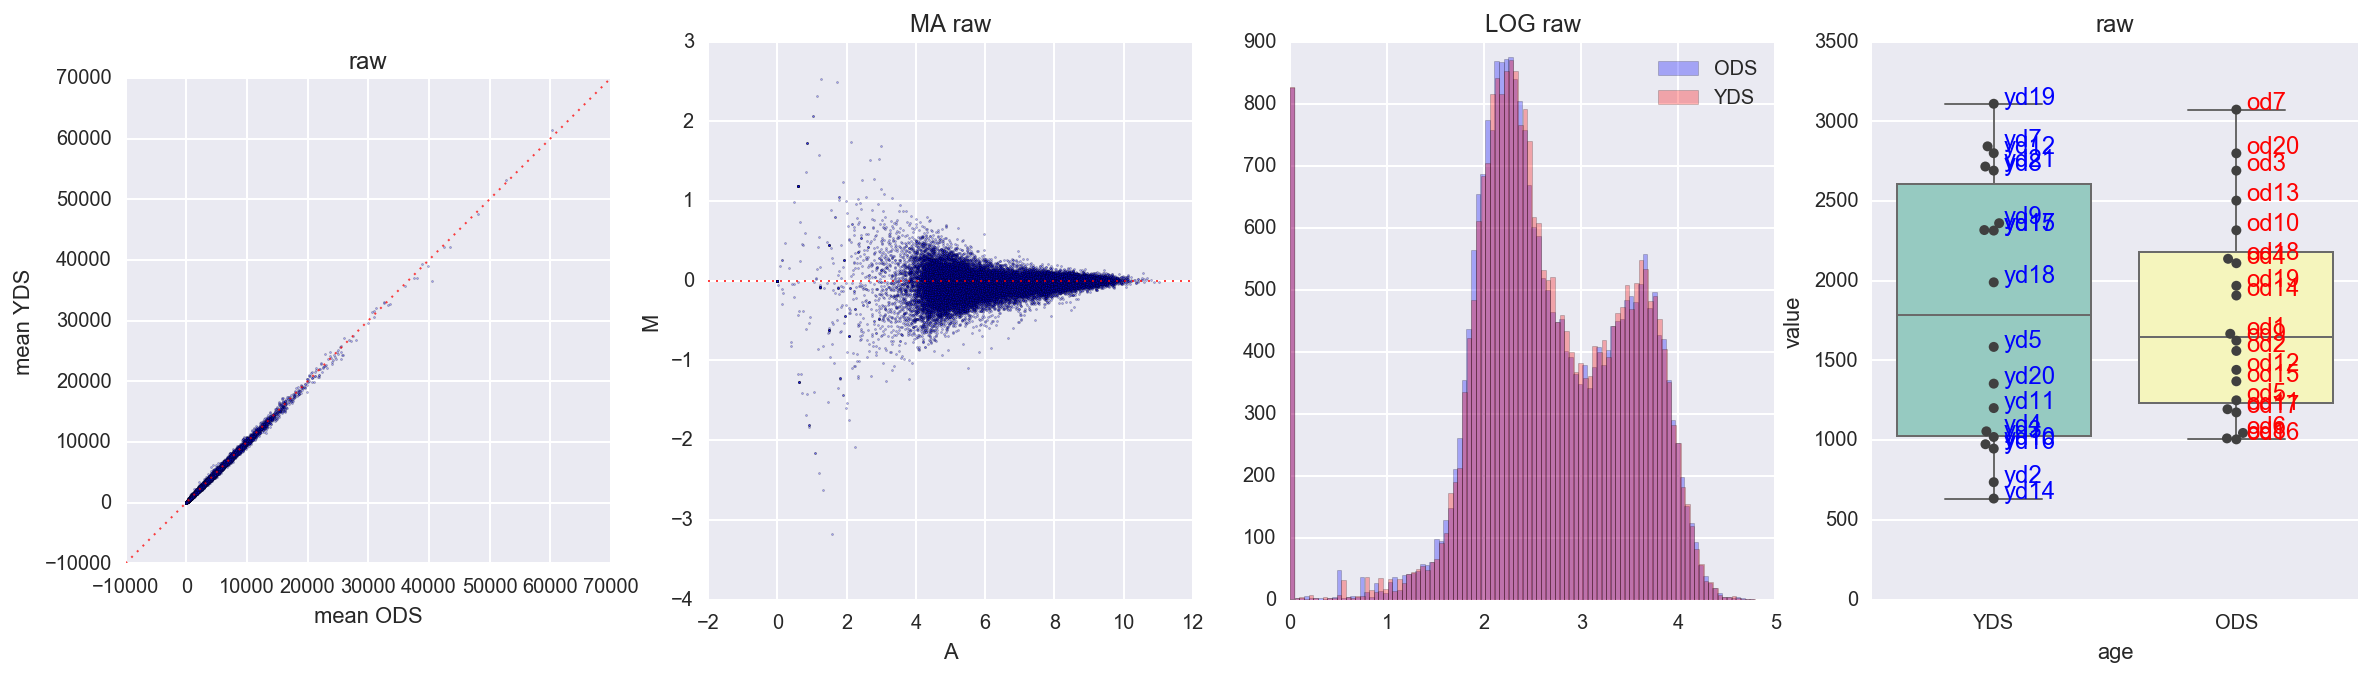

/Users/oleg/miniconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:184: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


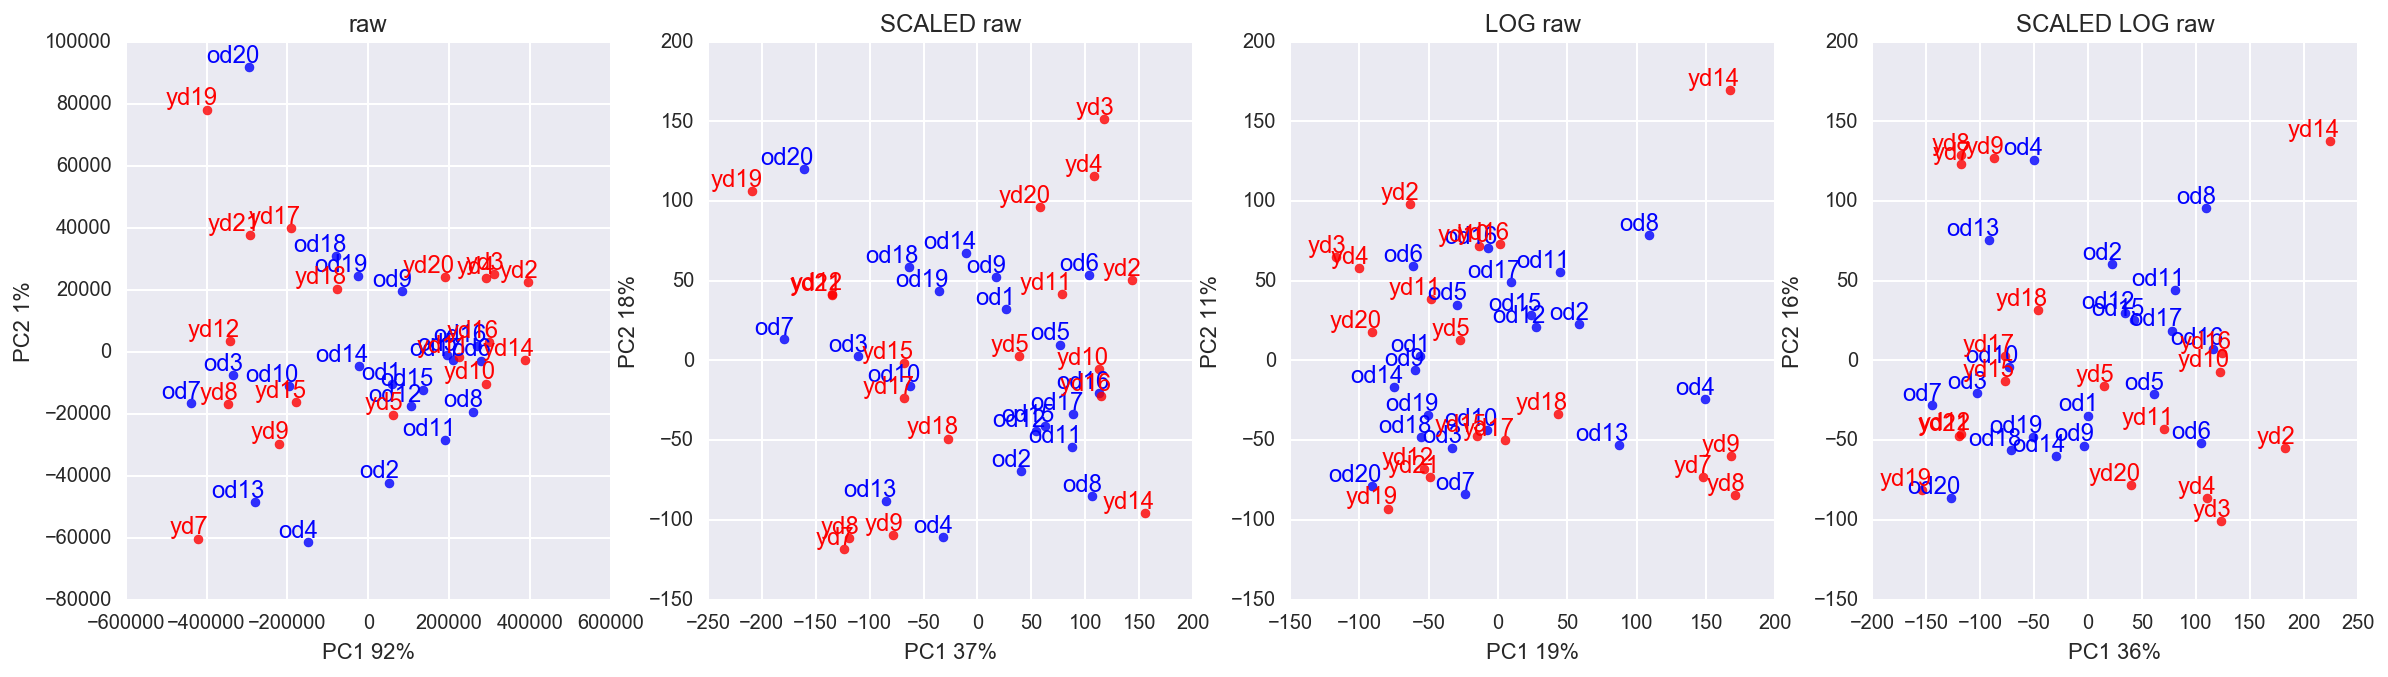

/mnt/stripe/bio/experiments/signal/H3K27ac/ucsc_cpgIslandExt.hg19/ucsc_cpgIslandExt.hg19_rpm.tsv


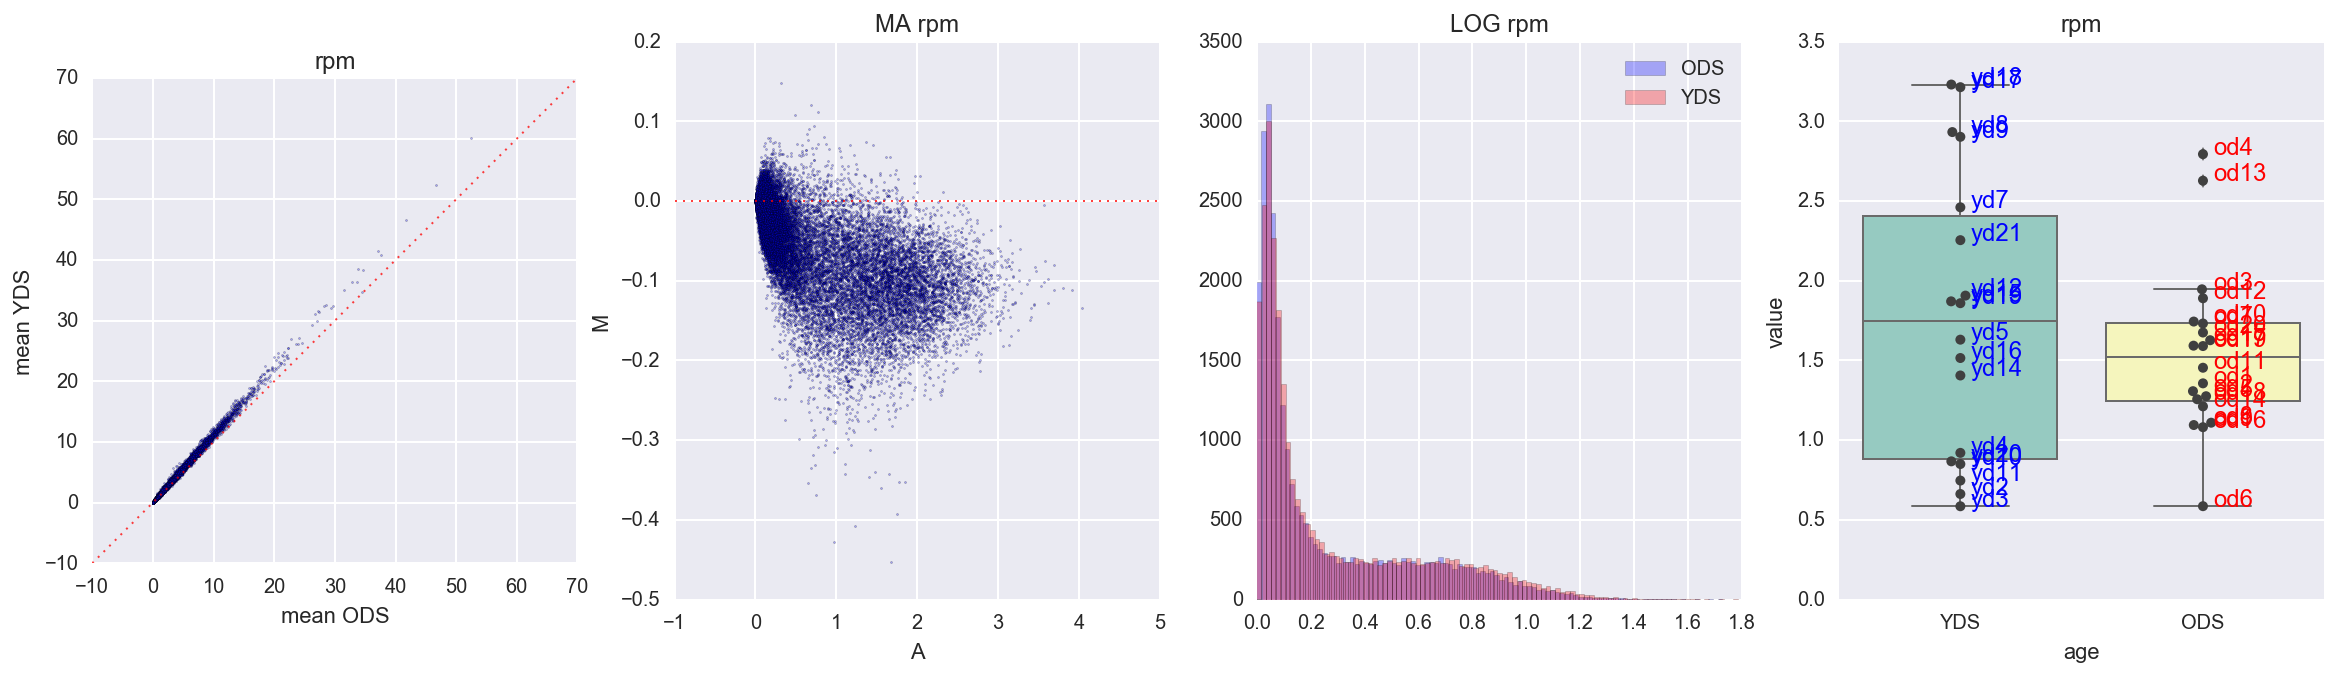

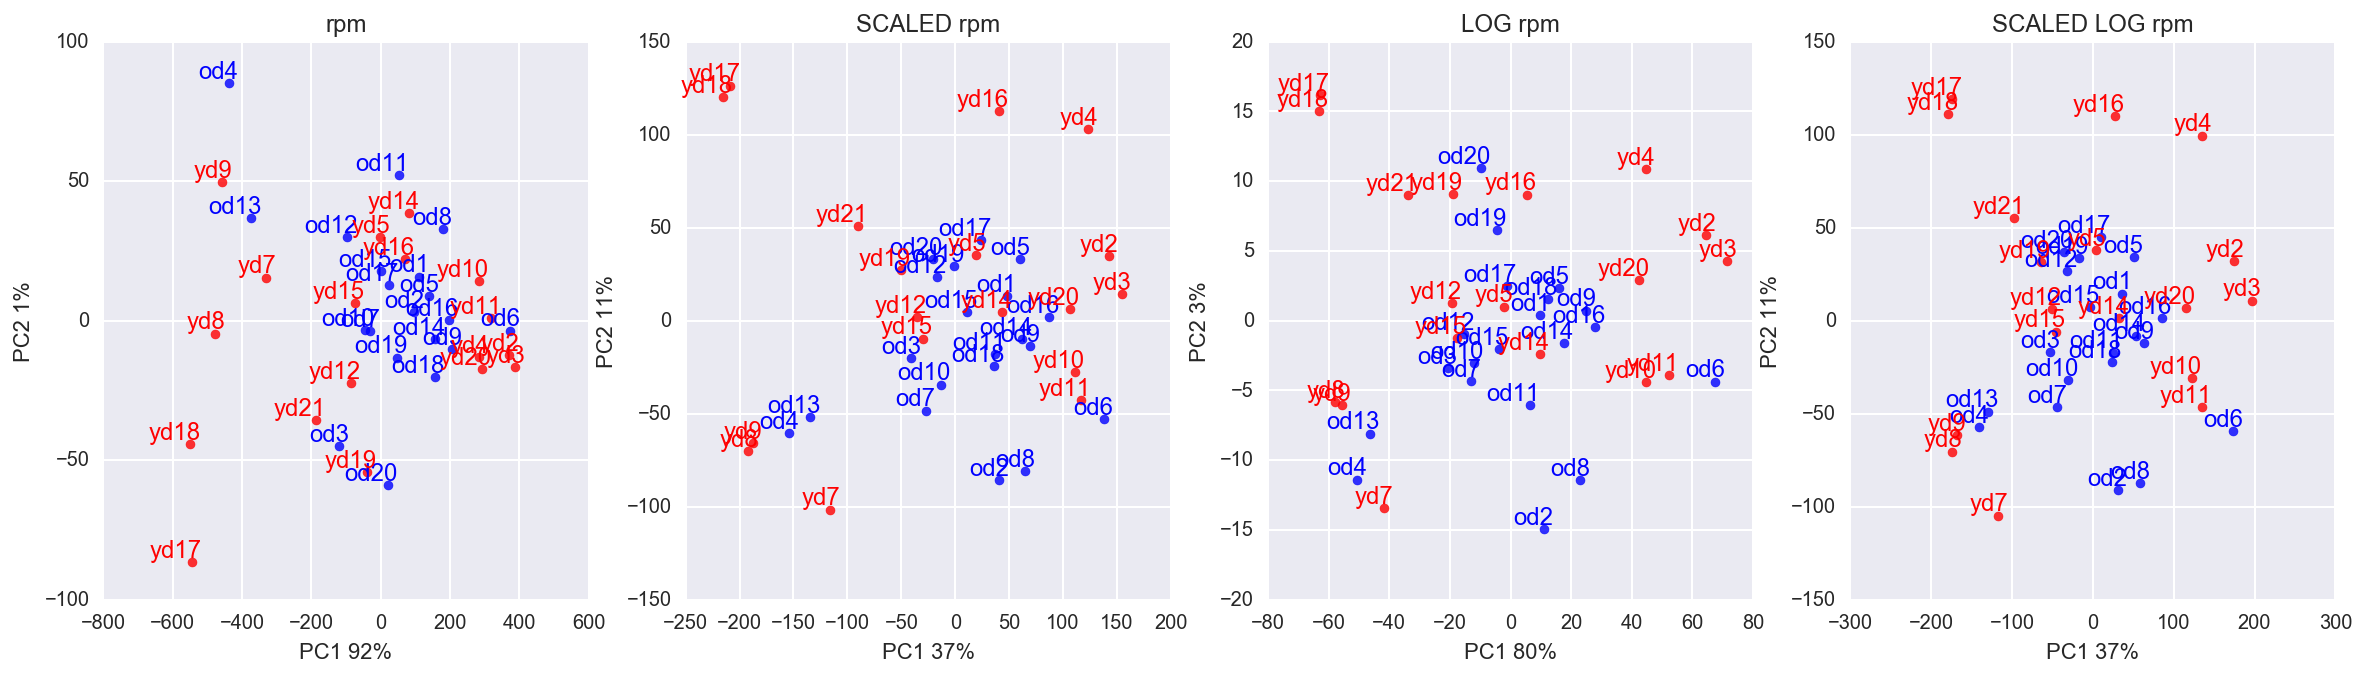

/mnt/stripe/bio/experiments/signal/H3K27ac/ucsc_cpgIslandExt.hg19/ucsc_cpgIslandExt.hg19_rpkm.tsv
File not found: /mnt/stripe/bio/experiments/signal/H3K27ac/ucsc_cpgIslandExt.hg19/ucsc_cpgIslandExt.hg19_rpkm.tsv
Processing diffbind normalization


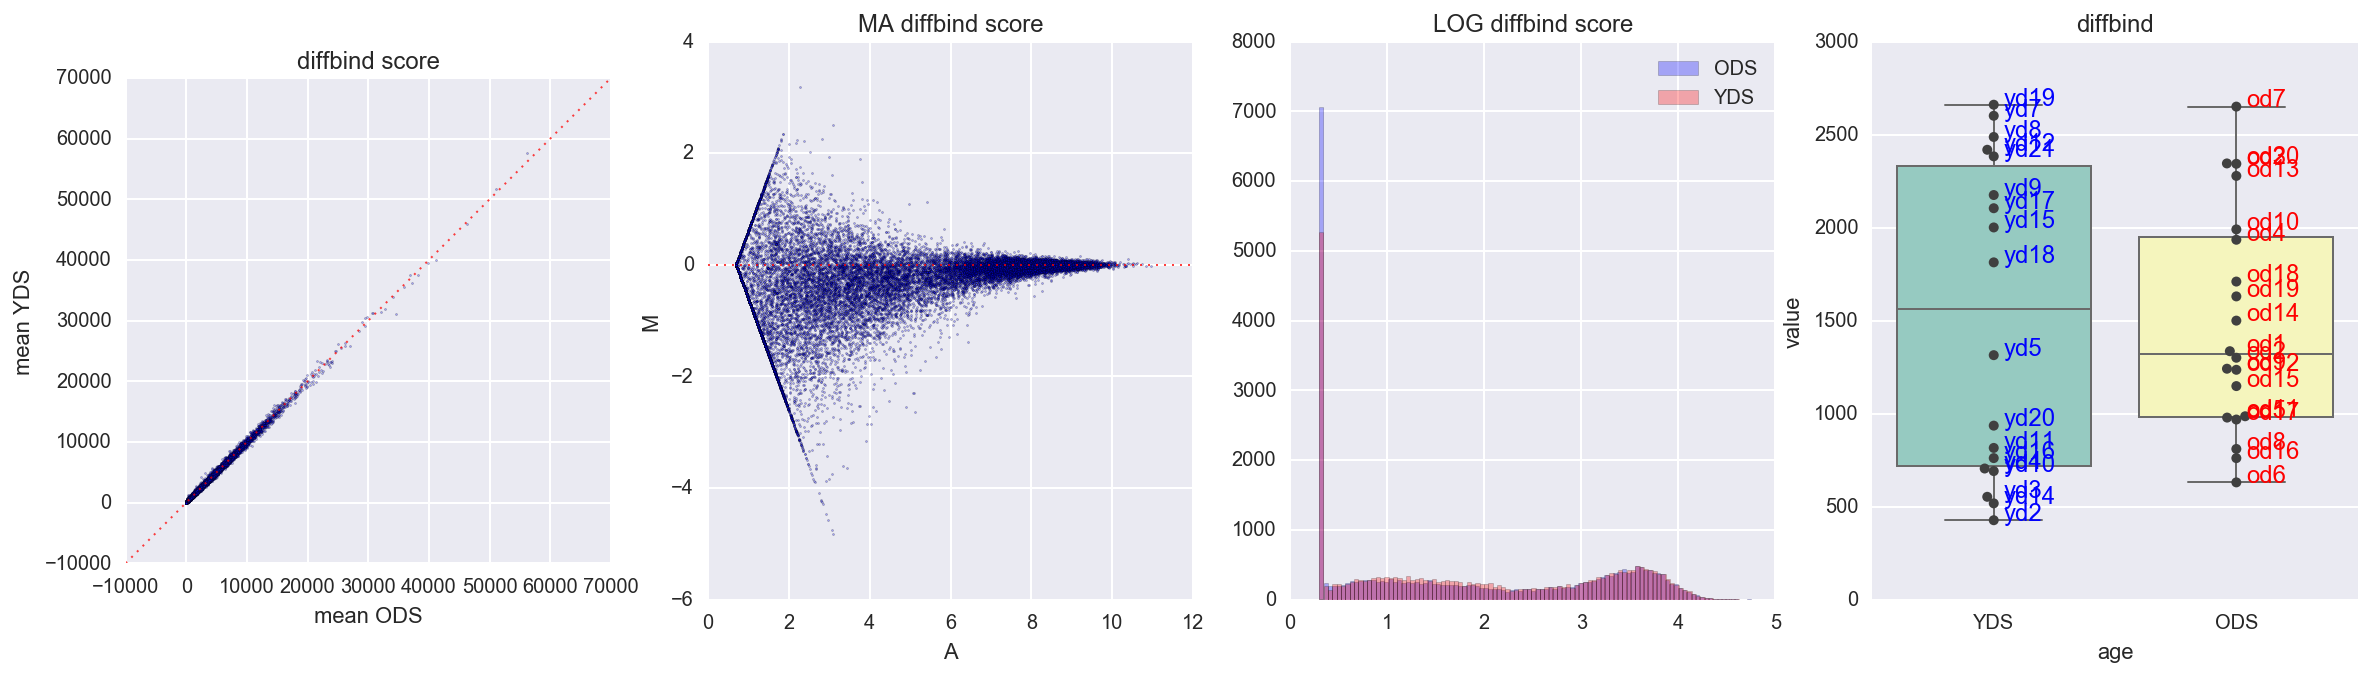

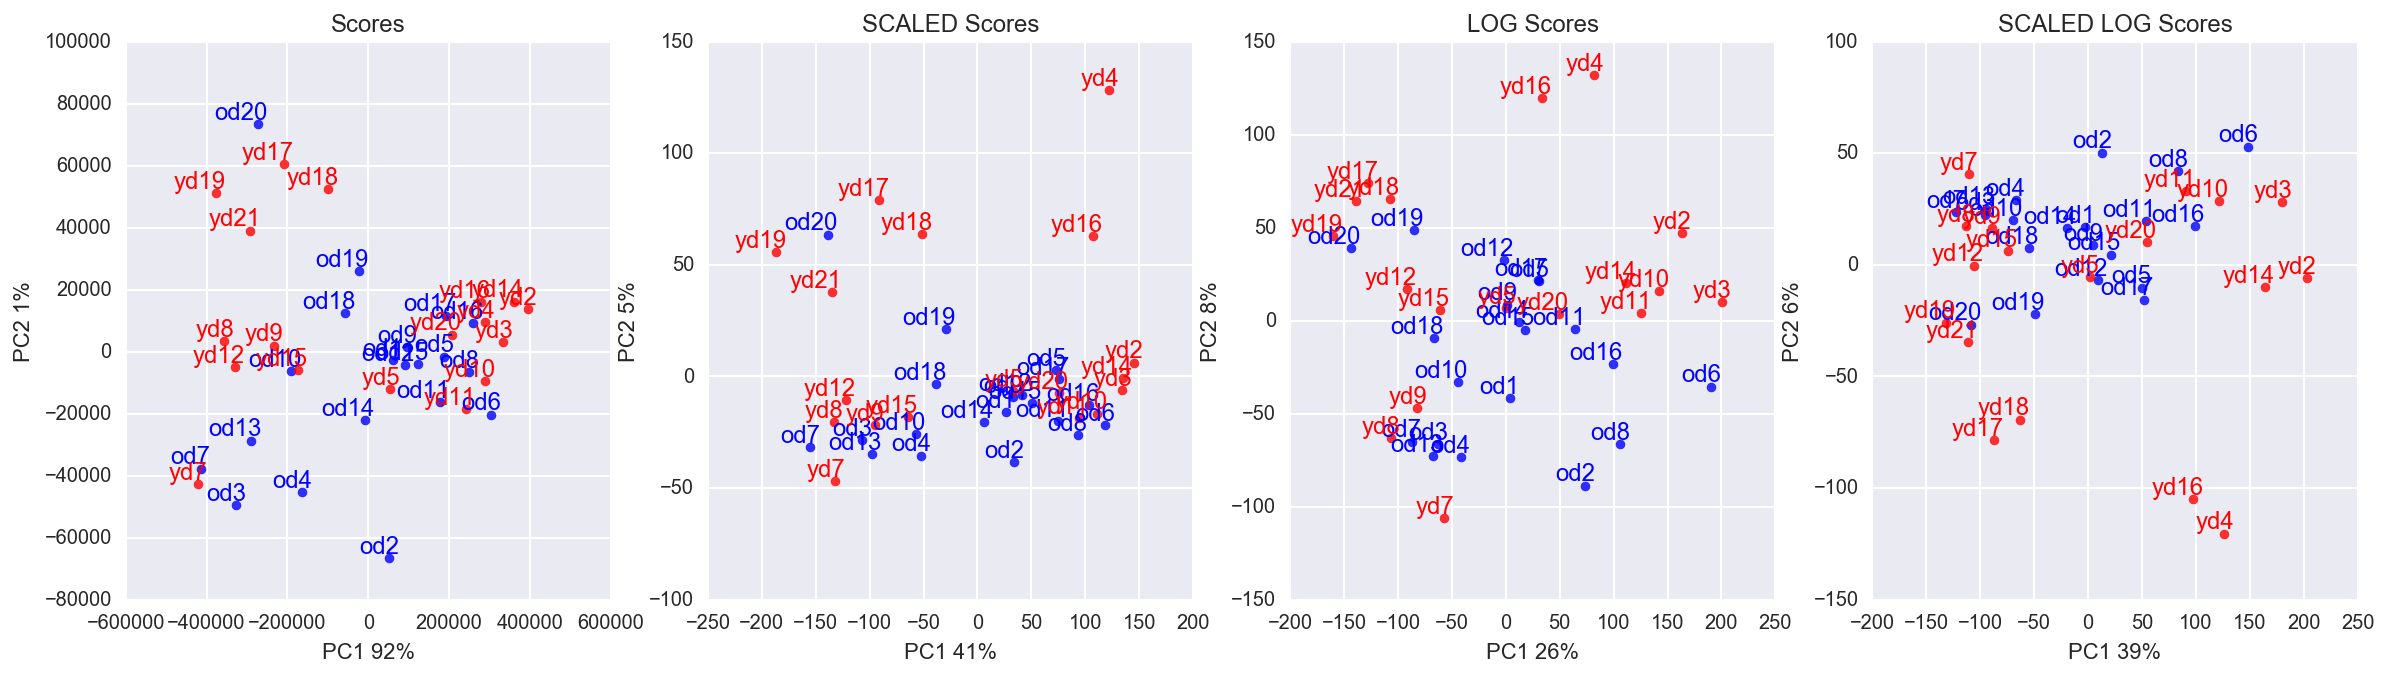

TMM normalization
Saved scores to /var/folders/td/g2ws4hwj5tj48_j_tsfz8_tc0000gp/T/scoreseqz4wkag.tsv
Saved sizes to /var/folders/td/g2ws4hwj5tj48_j_tsfz8_tc0000gp/T/sizes9sw235ui.tsv
TMM normalization using R
TMM Scores DBA_SCORE_TMM_MINUS_FULL_CPM


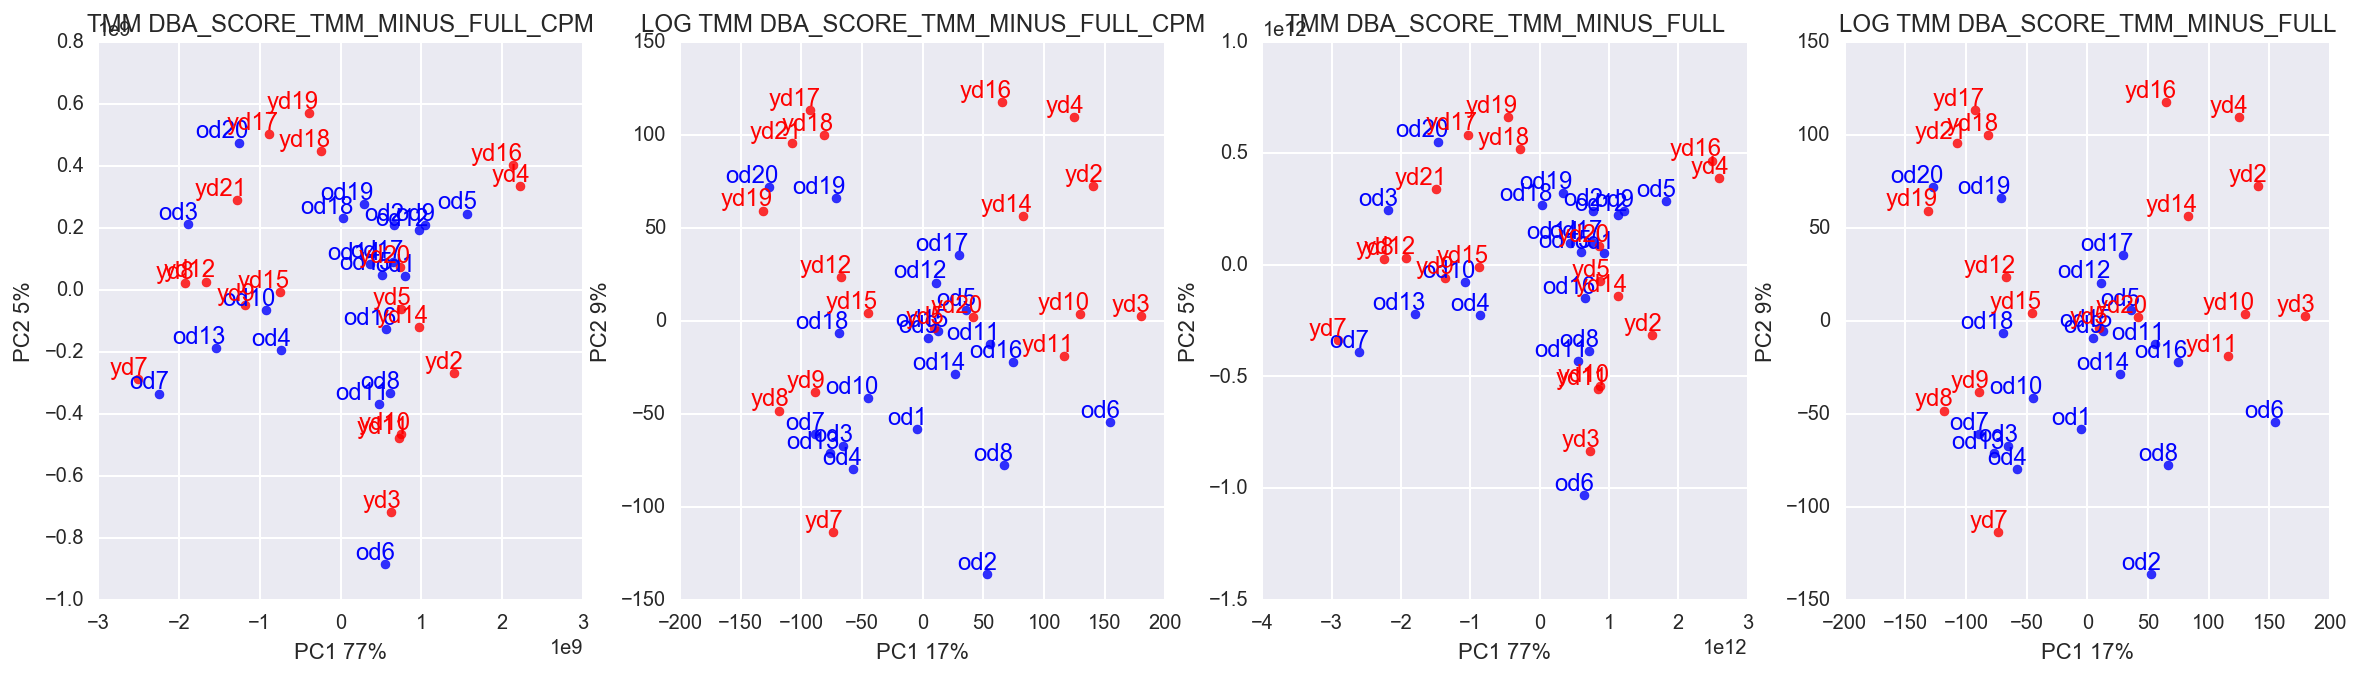

In [22]:
# import os
# folder = '/mnt/stripe/bio/experiments/signal/H3K27ac'
# for f in os.listdir(folder):
#     if (os.path.isdir(os.path.join(folder, f))):
#         process(folder, f)
        
process('/mnt/stripe/bio/experiments/signal/H3K27ac', 'ucsc_cpgIslandExt.hg19')